## Imports 


In [3]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
# Import matplotlib for visualization
import matplotlib.pyplot as plt
import numpy as np
# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldnt' be lower than 0.11
print(f'PyTorch version: {torch.__version__}\ntorchvision version: { torchvision.__version__}')

from collections import Counter
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import random
from collections import defaultdict
import pandas as pd

PyTorch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118


##Load data

In [ ]:
!mkdir data

In [4]:
all_data = datasets.LFWPeople(
    root="/content/data", # where to download data to?
    split = "10fold", # get all data
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None, # you can transform labels as well
    download=True # download data if it doesn't exist on disk
)

Files already downloaded and verified


In [3]:
all_data


Dataset LFWPeople
    Number of datapoints: 13233
    Root location: /content/data/lfw-py
    Alignment: funneled
    Split: 10fold
    Classes (identities): 5749
    StandardTransform
Transform: ToTensor()

Load all dataset names

In [8]:
# Open the text file containing the names of the people in the training dataset
with open("/content/data/lfw-py/lfw-names.txt") as f:
    # Read the contents of the file and split it into a list of names
    names = [name.split("\t")[0] for name in f.read().splitlines()]

## Check, how data looks


Look at random value from dataset. Should be (tensor [ ], int)

In [5]:
image, label = all_data[0]
image, label

(tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.6510, 0.6510, 0.0000],
          [0.0078, 0.0078, 0.0039,  ..., 0.6549, 0.6431, 0.6549],
          [0.0039, 0.0039, 0.0118,  ..., 0.6549, 0.6667, 0.6588],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0118, 0.0039, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.6784, 0.6902, 0.0157],
          [0.0039, 0.0039, 0.0000,  ..., 0.6941, 0.6824, 0.6941],
          [0.0000, 0.0000, 0.0078,  ..., 0.6980, 0.7098, 0.7020],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.6510, 0.6588, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.6627, 0.6510, 0.6627],
          [0.0000, 0.0000, 0.0000,  ...,

Let's look at top 10 labels which have the most images per label

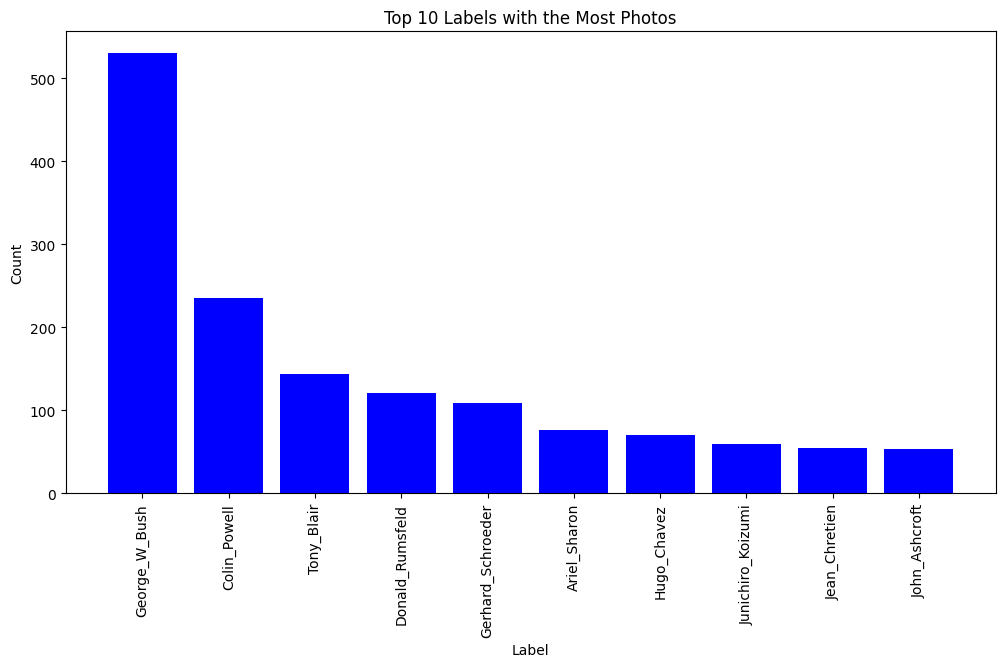

In [6]:
# Get the label counts
label_counts = Counter(all_data.targets)

# Sort the labels by count
sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 labels with the most and least number of photos
top_10_most = sorted_labels[:10]
top_10_least = sorted_labels[-10:]

# Extract the label names and counts for plotting
most_labels = [names[idx] for idx, count in top_10_most]
most_counts = [count for idx, count in top_10_most]
least_labels = [names[idx] for idx, count in top_10_least]
least_counts = [count for idx, count in top_10_least]

# Create a bar chart for the top 10 labels with the most photos
plt.figure(figsize=(12, 6))
plt.bar(most_labels, most_counts, color='b')
plt.title('Top 10 Labels with the Most Photos')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()



From the graph we can see that we have labels which have much more images than others labels. In data feature engineering we fix that labels which have more than 50 images.

Look at top 10 labels which have the least images per label

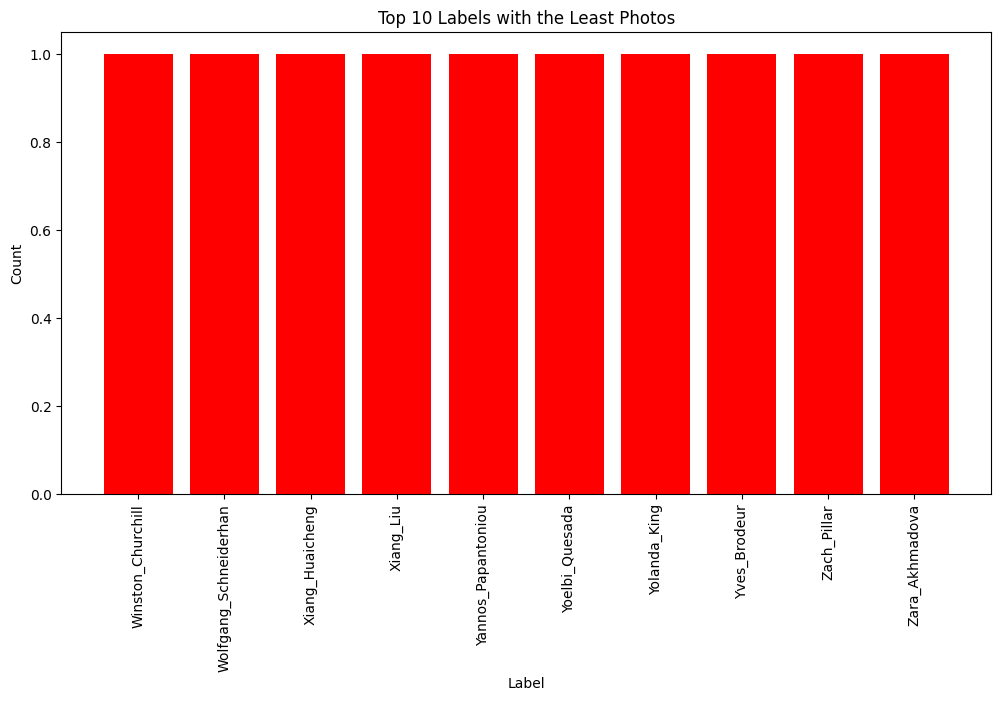

In [7]:
# Create a bar chart for the top 10 labels with the least photos
plt.figure(figsize=(12, 6))
plt.bar(least_labels, least_counts, color='r')
plt.title('Top 10 Labels with the Least Photos')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

As we see all 10 labels have 1 image, let's see how much labels have less than 10 images

In [14]:
# Get the label counts
label_counts = torch.bincount(torch.tensor(all_data.targets))

# Count the number of labels with less than 10 images
num_labels_less_than_10 = (label_counts < 10).sum().item()

print(f"Number of labels with less than 20 images: {num_labels_less_than_10}")

Number of labels with less than 20 images: 5591


As we see most of labels have less than 10 images per label, that not good for our model training, so in data feature engineering we need to clear that data.

## Data feature engineering

Delete all images and labels who have less than 10 images per label

In [5]:
# Create a list of identity counts
identity_counts = [list(all_data.targets).count(i) for i in range(len(set(all_data.targets)))]

# Iterate through the dataset in reverse order and remove the samples with less than 10 images
for i in reversed(range(len(all_data))):
    if identity_counts[all_data.targets[i]] < 10:
        all_data.data.pop(i)
        all_data.targets.pop(i)
    


# Print the number of samples and identities in the modified dataset
print("Number of images:", len(all_data))
print("Classes (identities):", len(set(all_data.targets)))

Number of images: 4324
Classes (identities): 158


Fix all labels which have more than 50 images/label 

In [6]:
for _ in range(0,6):
  # Convert the list of targets to a Tensor
  targets = torch.tensor(all_data.targets)
  # Count the number of images per label
  counts = torch.bincount(targets)

  # Iterate through the dataset and remove images from labels with more than 50 images

  for i, (image, label) in enumerate(all_data):
      if counts[label] > 50:
          if random.random() > 50 / counts[label]:
              # Remove the image and update the counts
              all_data.data.pop(i)
              all_data.targets.pop(i)
              counts[label] -= 1

# Print the number of samples and identities in the modified dataset
print("Number of datapoints:", len(all_data))
print("Classes (identities):", len(set(all_data.targets)))

Number of datapoints: 3368
Classes (identities): 158


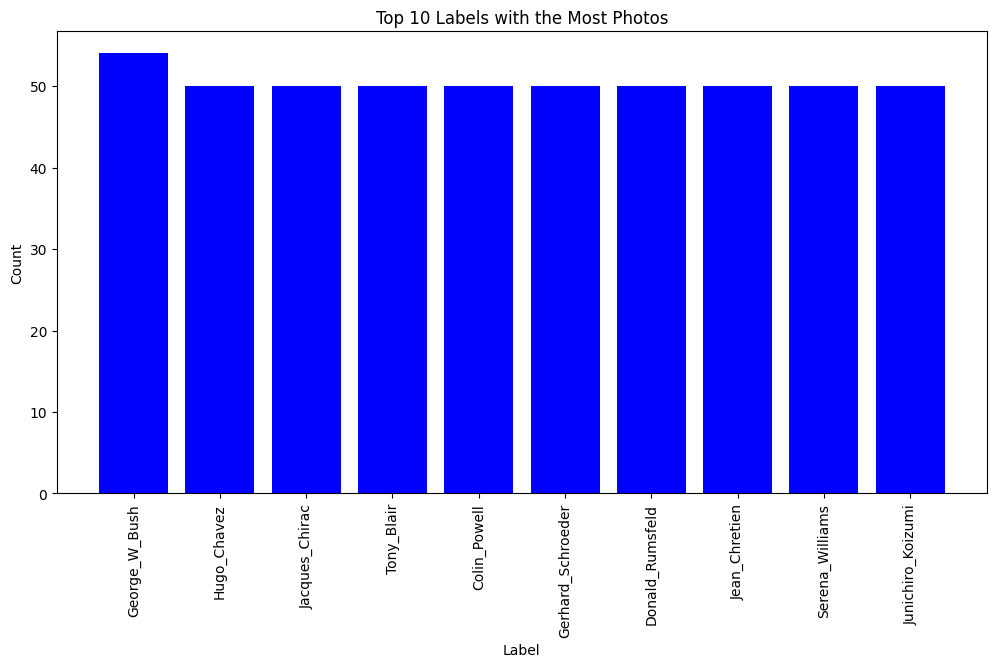

In [9]:
label_counts = Counter(all_data.targets)
sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
top_10_most = sorted_labels[:10]
top_10_least = sorted_labels[-10:]
most_labels = [names[idx] for idx, count in top_10_most]
most_counts = [count for idx, count in top_10_most]
least_labels = [names[idx] for idx, count in top_10_least]
least_counts = [count for idx, count in top_10_least]

# Create a bar chart for the top 10 labels with the most photos
plt.figure(figsize=(12, 6))
plt.bar(most_labels, most_counts, color='b')
plt.title('Top 10 Labels with the Most Photos')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

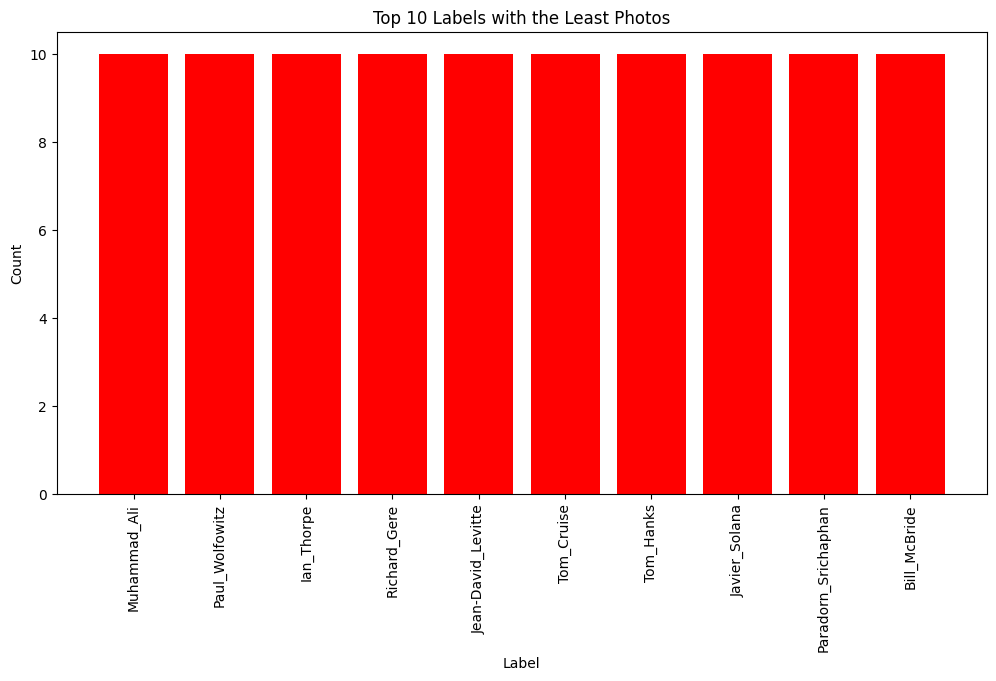

In [18]:
# Create a bar chart for the top 10 labels with the least photos
plt.figure(figsize=(12, 6))
plt.bar(least_labels, least_counts, color='r')
plt.title('Top 10 Labels with the Least Photos')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

After fix value above 50 and remove those who got less than 20, we need to check how much labels have less than 30 images per label. 30 are mean of values 10-50

In [10]:
# Create a defaultdict to keep track of the number of images per label
num_images_per_label = defaultdict(int)

# Iterate through the dataset and count the number of images per label
for i in range(len(all_data)):
    image, label = all_data[i]
    num_images_per_label[label] += 1

# Count the number of labels with less than 30 images
count = 0
for label in num_images_per_label:
    if num_images_per_label[label] < 30:
        count += 1

print("Number of labels with less than 30 images:", count,"of",len(set(all_data.targets)))

Number of labels with less than 30 images: 124 of 158


As we can see more than half labels have less images than mean. So now we fix it with augmentation techniques.

In [11]:
import torchvision.transforms.functional as F

class GaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

This cell take long run ( for me its took around 13min)

In [12]:
# Create a dictionary to store the counts for each label
label_counts = {}

# Loop through the dataset and count the number of images for each label
for i in range(len(all_data)):
    _, label = all_data[i]
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

# Find all labels with less than 42 images
labels_to_augment = [label for label, count in label_counts.items() if count < 42]

# Define the transforms to use for the image augmentation
rotation_transform = transforms.RandomRotation(degrees=15)
horizontal_flip_transform = transforms.RandomHorizontalFlip()
color_jitter_transform = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
resize_crop_transform = transforms.RandomResizedCrop(size=(250, 250), scale=(0.8, 1.0))
gaussian_noise_transform = transforms.Lambda(lambda x: GaussianNoise(mean=0, std=0.1)(x))

# Create a new list to store all the data, including augmented images
alll_data = list(all_data)

# Loop through the labels to augment
for label in labels_to_augment:
    # Create a list of indices for all images with the current label
    label_indices = [i for i in range(len(all_data)) if all_data[i][1] == label]
    # Loop until the label has 42 images
    while label_counts[label] < 42:
        # Choose a random image index to augment
        image_index = label_indices[torch.randint(len(label_indices), size=(1,)).item()]
        # Load the image and apply a random augmentation
        image, _ = all_data[image_index]
        transform_choice = torch.randint(5, size=(1,)).item()
        if transform_choice == 0:
            image = rotation_transform(image)
        elif transform_choice == 1:
            image = horizontal_flip_transform(image)
        elif transform_choice == 2:
            image = color_jitter_transform(image)
        elif transform_choice == 3:
            image = resize_crop_transform(image)
        elif transform_choice == 4:
            image = gaussian_noise_transform(image)
        # Add the augmented image to the dataset
        alll_data.append((image, label))
        # Update the label count
        label_counts[label] += 1
        
# Separate the images and labels into separate lists
images = [x[0] for x in alll_data]
labels = [x[1] for x in alll_data]




/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [13]:
# Create a PyTorch dataset from the lists
class MyDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

new_dataset = MyDataset(images, labels)

In [14]:
new_dataset[0]

(tensor([[[0.0078, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.4706, 0.4784, 0.4863,  ..., 0.0000, 0.0000, 0.0000],
          [0.4784, 0.4863, 0.5020,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.3333, 0.3294, 0.2784,  ..., 0.0000, 0.0000, 0.0000],
          [0.2980, 0.2667, 0.2275,  ..., 0.0000, 0.0000, 0.0000],
          [0.2667, 0.2353, 0.1961,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0078, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.4706, 0.4784, 0.4902,  ..., 0.0000, 0.0000, 0.0000],
          [0.4784, 0.4824, 0.5059,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2196, 0.2588, 0.2824,  ..., 0.0000, 0.0000, 0.0000],
          [0.2745, 0.2824, 0.2980,  ..., 0.0000, 0.0000, 0.0000],
          [0.2784, 0.2784, 0.2902,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.4392, 0.4471, 0.4667,  ..., 0.0000, 0.0000, 0.0000],
          [0.4471, 0.4627, 0.4863,  ...,

In [130]:
print("Classes (identities):", len(set(new_dataset.labels)))

Classes (identities): 158


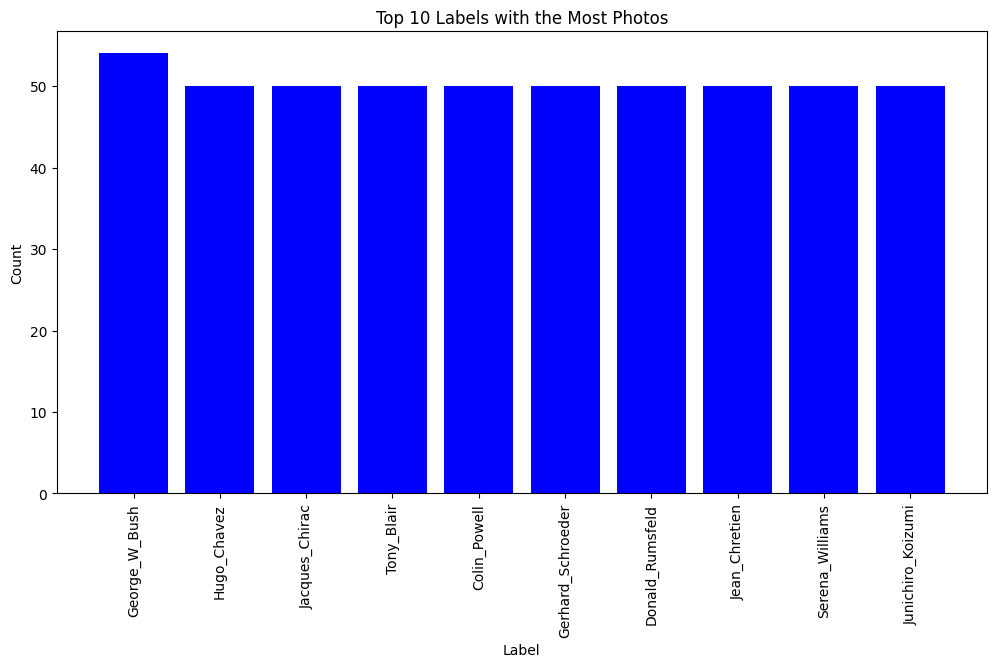

In [15]:
label_counts = Counter(new_dataset.labels)
sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
top_10_most = sorted_labels[:10]
top_10_least = sorted_labels[-10:]
most_labels = [names[idx] for idx, count in top_10_most]
most_counts = [count for idx, count in top_10_most]
least_labels = [names[idx] for idx, count in top_10_least]
least_counts = [count for idx, count in top_10_least]

# Create a bar chart for the top 10 labels with the most photos
plt.figure(figsize=(12, 6))
plt.bar(most_labels, most_counts, color='b')
plt.title('Top 10 Labels with the Most Photos')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

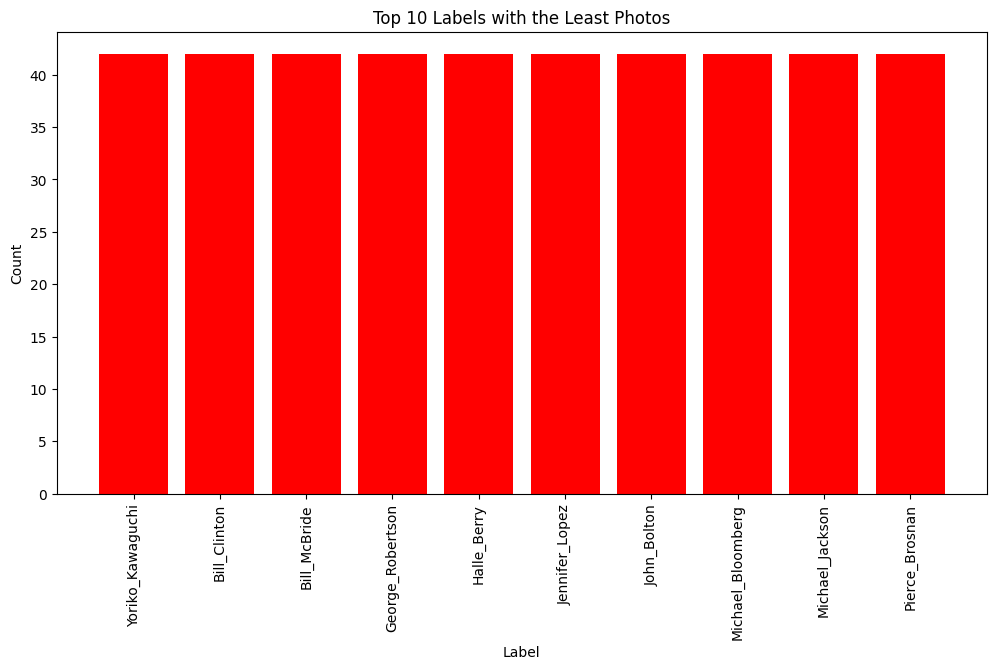

In [132]:
# Create a bar chart for the top 10 labels with the least photos
plt.figure(figsize=(12, 6))
plt.bar(least_labels, least_counts, color='r')
plt.title('Top 10 Labels with the Least Photos')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [16]:
# Encode the targets
le = LabelEncoder()
new_dataset.labels = le.fit_transform(new_dataset.labels)

# Check the encoded targets
print("Encoded targets:", new_dataset.labels)

Encoded targets: [  8   8   8 ... 120 120 120]


In [17]:
# Decode the targets
decoded_targets = le.inverse_transform(new_dataset.labels)
print("Decoded targets:", decoded_targets)

Decoded targets: [ 317  317  317 ... 4403 4403 4403]


In [18]:
import random
from torch.utils.data import Subset
# Split the dataset into training and test sets
n_samples = len(new_dataset)
train_size = int(0.8 * n_samples)

test_size = n_samples - train_size

indices = list(range(n_samples))
random.shuffle(indices)

train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_data = Subset(new_dataset, train_indices)
test_data = Subset(new_dataset, test_indices)

# Print the number of samples and identities in each set
print("Number of datapoints in the training set:", len(train_data))
print("Number of datapoints in the test set:", len(test_data))
print("Classes (identities) in the training set:", len(set(train_data.dataset.labels)))
print("Classes (identities) in the test set:", len(set(test_data.dataset.labels)))

Number of datapoints in the training set: 5400
Number of datapoints in the test set: 1351
Classes (identities) in the training set: 158
Classes (identities) in the test set: 158


Image shape: torch.Size([3, 250, 250])


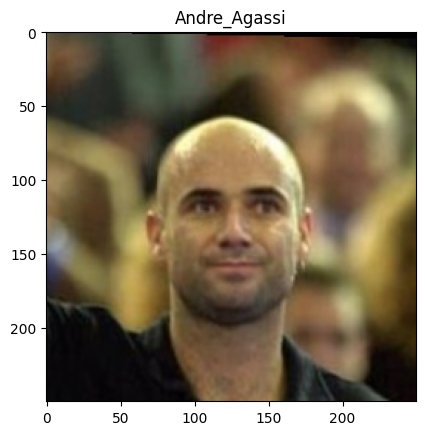

In [19]:
image, label = new_dataset[450]
print(f'Image shape: {image.shape}')
plt.imshow(image.permute(1,2,0)) # image shape is [3, 224, 224] (colour_channel, height, width)
plt.title(names[le.inverse_transform([label])[0]]);

In [20]:
name_to_find = "Gerhard_Schroeder"
num_images = 0
for target in new_dataset.labels:
    name = names[le.inverse_transform([target])[0]]
    if name == name_to_find:
        num_images += 1

print(f"Number of images for {name_to_find}: {num_images}")

Number of images for Gerhard_Schroeder: 50


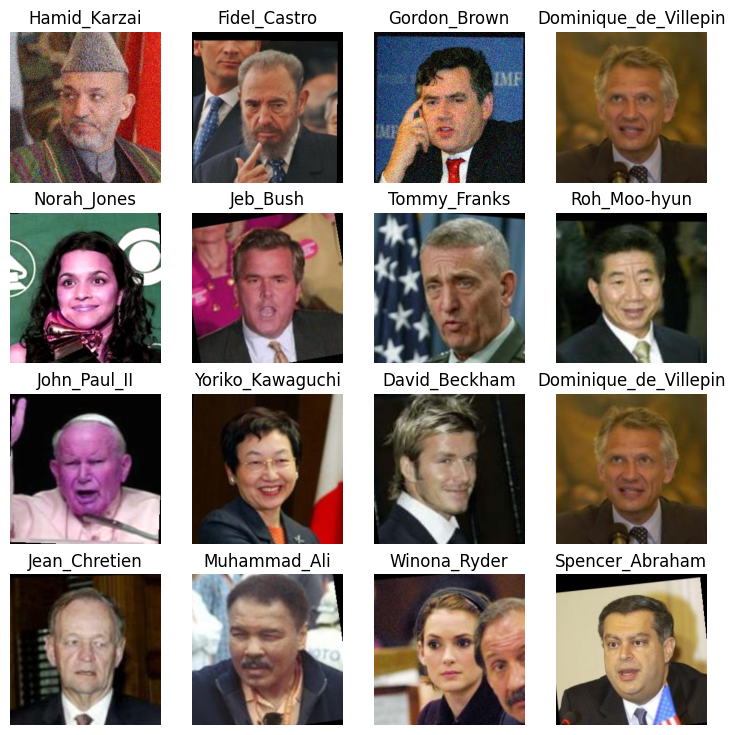

In [21]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows * cols +1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1,2,0))
  plt.title(names[le.inverse_transform([label])[0]])
  plt.axis(False);

In [22]:
# Setup the batch size hyperparamete
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
      batch_size = BATCH_SIZE, # how many sample per batch?
      shuffle = True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data, 
      batch_size = BATCH_SIZE, 
      shuffle = False # don't necessarily have shuffle the testing data
)

# Let's check what we've created
print(f'DataLoaders: {train_dataloader, test_dataloader}')
print(f'Length of train dataloder: {len(train_dataloader)} batches of {BATCH_SIZE}')
print(f'Length of test dataloder: {len(test_dataloader)} batches of {BATCH_SIZE}')

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f9ffc770730>, <torch.utils.data.dataloader.DataLoader object at 0x7f9ffc7190a0>)
Length of train dataloder: 169 batches of 32
Length of test dataloder: 43 batches of 32


In [23]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 250, 250]), torch.Size([32]))

Image size: torch.Size([3, 250, 250])
Label: 24, label size: torch.Size([])


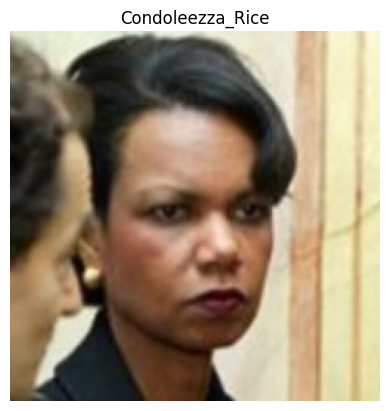

In [24]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.permute(1,2,0))
plt.title(names[le.inverse_transform([label])[0]])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [26]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader,device: torch.device = device):
   
    loss, acc = 0, 0
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device) 

            # Make predictions with the model
            y_pred = model(images)
            
            log_probabilities = model(images)
            loss += criterion(log_probabilities, labels).item()

            probabilites = torch.exp(log_probabilities)
            top_prob, top_class = probabilites.topk(1, dim=1)
            predictions = top_class == labels.view(*top_class.shape)
            acc += torch.mean(predictions.type(torch.FloatTensor))
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss,
            "model_acc": acc}

In [27]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [145]:
class CNNnetwork(nn.Module):
  def __init__(self):
    super(CNNnetwork, self).__init__()
    # Convolutional Neural Network layer
    self.convolutional_neural_network_layers = nn.Sequential(
        # We caclute the output of each covoluion layer using the formula:
        # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
        nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, padding=1, stride=1),  # (N, 1, 28, 28)
        nn.ReLU(),
        # After the first convolutional layer the output of this layer is:
        # [(250 + 2*1 - 3) /1] + 1 = 250
        #nn.MaxPool2d(kernel_size=2),
        # Since we applied maxxpooling with kernel_size =2 we have to divide by 2 and we get:
        # 250 / 2 = 125
        # Output of our second convultion layer
        nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        # After the second convolutional layer output of our second convultion layer the output of this layer will be:
        # [(125 + 2*1 - 4)/1] + 1  = 124
        nn.MaxPool2d(kernel_size=2),
        # Since we applined maxpooling with kernel_size=2 we have divide by 2 and we get then:
        # 125 / 2 = 62
        # [(62 + 2*1 - 3)/1] + 1  = 62
        nn.Conv2d(in_channels=24, out_channels=36, kernel_size=4, padding=1, stride=1),
        nn.ReLU(),
         # [(62 + 2*1 - 3)/1] + 1  = 62   
        nn.Conv2d(in_channels=36, out_channels=36, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        #62/2 = 31
        nn.MaxPool2d(kernel_size=2)
    )




    # Linear Layer
    self.linear_layers = nn.Sequential(
        # We have the output channels of 96 of our second convolutional and 31*31 from formula
        # which give us the output of each convolutional layer
        nn.Flatten(),
        #nn.Linear(in_features=24*62*62, out_features=4612),
        #nn.ReLU(),
        #nn.Dropout(p=0.2),
        nn.Linear(in_features=36*62*62, out_features=len(set(new_dataset.labels)))
    )

  # Defining forward pass
  def forward(self, x):
    x = self.convolutional_neural_network_layers(x)
    # After we get output of our convolutional layer we must flatten it 
    x = x.view(x.size(0), -1)
    # Then pass it through the linear layer
    x = self.linear_layers(x)
    # The softmax function returns the prob likelihood of getting the input image.
    # We will see a graphical demonstration below
    x = F.log_softmax(x, dim=1)
    return x

In [146]:
modelV1 = CNNnetwork()
modelV1.to(device)
print(modelV1)

CNNnetwork(
  (convolutional_neural_network_layers): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(24, 36, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(36, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=138384, out_features=158, bias=True)
  )
)


In [147]:
optimizer = optim.Adam(modelV1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [148]:
import torch.nn.functional as F
# Measure time
from timeit import default_timer as timer
train_time_start_model_1 = timer()

epochs = 10 # The total number of iteration

train_lossesV1 = []
test_lossesV1 = []

for epoch in range(epochs):
  # model for training
  modelV1.train()
  train_loss = 0

  for idx, (images, labels) in enumerate(train_dataloader):

    # Send these >>> To GPU
    images = images.to(device)
    labels = labels.to(device)

    # Training pass
    optimizer.zero_grad()

    # Forward pass
    output = modelV1(images)
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  else:
    # model for evaluation
    modelV1.eval()
    test_loss = 0
    accuracy = 0

    # Turn off gradients when performing evaluation.
    # As if we don't turn it off, we  will comprise our networks weight entirely
    with torch.no_grad():
      for images, labels in test_dataloader:

        images = images.to(device)
        labels = labels.to(device) 

        log_probabilities = modelV1(images)
        test_loss += criterion(log_probabilities, labels).item()

        probabilites = torch.exp(log_probabilities)
        top_prob, top_class = probabilites.topk(1, dim=1)
        predictions = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(predictions.type(torch.FloatTensor))

      train_lossesV1.append(train_loss/len(train_dataloader))
      test_lossesV1.append(test_loss/len(train_dataloader))

      print("Epoch: {}/{}   ".format(epoch+1, epochs),
            "Training loss: {:.4f}   ".format(train_loss/len(train_dataloader)),
            "Testing loss: {:.4f}   ".format(test_loss/len(train_dataloader)),
            "Test accuracy: {:.4f}   ".format(accuracy/len(test_dataloader)))
train_time_end_model_1 = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_model_1,
                                           end=train_time_end_model_1,
                                           device=device)

Epoch: 1/10    Training loss: 5.1251    Testing loss: 1.2670    Test accuracy: 0.0073   
Epoch: 2/10    Training loss: 4.5583    Testing loss: 1.0133    Test accuracy: 0.2315   
Epoch: 3/10    Training loss: 1.9132    Testing loss: 0.6810    Test accuracy: 0.4900   
Epoch: 4/10    Training loss: 0.4194    Testing loss: 0.7566    Test accuracy: 0.5562   
Epoch: 5/10    Training loss: 0.0682    Testing loss: 0.9776    Test accuracy: 0.5605   
Epoch: 6/10    Training loss: 0.0080    Testing loss: 1.2347    Test accuracy: 0.5671   
Epoch: 7/10    Training loss: 0.0003    Testing loss: 1.4182    Test accuracy: 0.5613   
Epoch: 8/10    Training loss: 0.0001    Testing loss: 1.4791    Test accuracy: 0.5634   
Epoch: 9/10    Training loss: 0.0001    Testing loss: 1.5193    Test accuracy: 0.5620   
Epoch: 10/10    Training loss: 0.0000    Testing loss: 1.5506    Test accuracy: 0.5620   
Train time on cuda: 165.397 seconds


In [149]:
# Calculate model 1 results
model_1_results = eval_model(model=modelV1, data_loader=test_dataloader,
    device=device
)
model_1_results

{'model_name': 'CNNnetwork',
 'model_loss': 6.094346539918766,
 'model_acc': tensor(0.5620)}

In [150]:
class DeepFace(nn.Module):
    def __init__(self):
        super(DeepFace, self).__init__()
        
        # 3D alignment network
        self.alignment = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(128 * 31 * 31, 128),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        
        # face recognition network
        self.recognition = nn.Sequential(
            nn.Linear(128, out_features=len(set(new_dataset.labels))),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.alignment(x)
        x = self.recognition(x)
        return x

In [151]:
modelV2 = DeepFace()
modelV2.to(device)
print(modelV2)

DeepFace(
  (alignment): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

In [152]:
optimizer = optim.Adam(modelV2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [153]:
# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs = 10 # The total number of iteration

train_lossesV2 = []
test_lossesV2 = []

for epoch in range(epochs):
  # model for training
  modelV2.train()
  train_loss = 0

  for idx, (images, labels) in enumerate(train_dataloader):

    # Send these >>> To GPU
    images = images.to(device)
    labels = labels.to(device)

    # Training pass
    optimizer.zero_grad()

    # Forward pass
    output = modelV2(images)
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  else:
    # model for evaluation
    modelV2.eval()
    test_loss = 0
    accuracy = 0

    # Turn off gradients when performing evaluation.
    # As if we don't turn it off, we  will comprise our networks weight entirely
    with torch.no_grad():
      for images, labels in test_dataloader:

        images = images.to(device)
        labels = labels.to(device) 

        log_probabilities = modelV2(images)
        test_loss += criterion(log_probabilities, labels).item()

        probabilites = torch.exp(log_probabilities)
        top_prob, top_class = probabilites.topk(1, dim=1)
        predictions = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(predictions.type(torch.FloatTensor))

      train_lossesV2.append(train_loss/len(train_dataloader))
      test_lossesV2.append(test_loss/len(train_dataloader))

      print("Epoch: {}/{}   ".format(epoch+1, epochs),
            "Training loss: {:.4f}   ".format(train_loss/len(train_dataloader)),
            "Testing loss: {:.4f}   ".format(test_loss/len(train_dataloader)),
            "Test accuracy: {:.4f}   ".format(accuracy/len(test_dataloader)))
      
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

Epoch: 1/10    Training loss: 5.0579    Testing loss: 1.2848    Test accuracy: 0.0247   
Epoch: 2/10    Training loss: 5.0183    Testing loss: 1.2737    Test accuracy: 0.0690   
Epoch: 3/10    Training loss: 4.9386    Testing loss: 1.2595    Test accuracy: 0.1359   
Epoch: 4/10    Training loss: 4.8489    Testing loss: 1.2453    Test accuracy: 0.1959   
Epoch: 5/10    Training loss: 4.7387    Testing loss: 1.2277    Test accuracy: 0.2864   
Epoch: 6/10    Training loss: 4.6248    Testing loss: 1.2056    Test accuracy: 0.3687   
Epoch: 7/10    Training loss: 4.5329    Testing loss: 1.1917    Test accuracy: 0.4406   
Epoch: 8/10    Training loss: 4.4602    Testing loss: 1.1811    Test accuracy: 0.4809   
Epoch: 9/10    Training loss: 4.3823    Testing loss: 1.1628    Test accuracy: 0.5536   
Epoch: 10/10    Training loss: 4.3195    Testing loss: 1.1553    Test accuracy: 0.5889   
Train time on cuda: 927.893 seconds


In [154]:
# Calculate model 1 results
model_2_results = eval_model(model=modelV2, data_loader=test_dataloader,
    device=device
)
model_2_results

{'model_name': 'DeepFace',
 'model_loss': 4.540584575298221,
 'model_acc': tensor(0.5889)}

In [37]:
class DeepID(nn.Module):
    def __init__(self):
        super(DeepID, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(3, 20, kernel_size=4, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(20)
        self.rel1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Second convolutional block
        self.conv2 = nn.Conv2d(20, 40, kernel_size=3, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(40)
        self.rel2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Third convolutional block
        self.conv3 = nn.Conv2d(40, 60, kernel_size=3, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(60)
        self.rel3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc4 = nn.Linear(60 * 29 * 29, 160)
        self.bn4 = nn.BatchNorm1d(160)
        self.rel4 = nn.ReLU()
        self.fc5 = nn.Linear(160, out_features=len(set(new_dataset.labels)))

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.rel1(x)
        x = self.pool1(x)

        # Second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.rel2(x)
        x = self.pool2(x)

        # Third convolutional block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.rel3(x)
        x = self.pool3(x)

        # Flatten the output from convolutional blocks
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.rel4(x)

        x = self.fc5(x)

        return x

In [38]:
modelV3 = DeepID()
modelV3.to(device)
print(modelV3)

DeepID(
  (conv1): Conv2d(3, 20, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(40, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc4): Linear(in_features=50460, out_features=160, bias=True)
  (bn4): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel4): ReLU()
  (fc5): Linear(in_features=160, out_features=158, bias=True)
)

In [39]:
optimizer = optim.Adam(modelV3.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [40]:
# Measure time
from timeit import default_timer as timer
train_time_start_model_3 = timer()

epochs = 10 # The total number of iteration

train_lossesV3 = []
test_lossesV3 = []

for epoch in range(epochs):
  # model for training
  modelV3.train()
  train_loss = 0

  for idx, (images, labels) in enumerate(train_dataloader):

    # Send these >>> To GPU
    images = images.to(device)
    labels = labels.to(device)

    # Training pass
    optimizer.zero_grad()

    # Forward pass
    output = modelV3(images)
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  else:
    # model for evaluation
    modelV3.eval()
    test_loss = 0
    accuracy = 0

    # Turn off gradients when performing evaluation.
    # As if we don't turn it off, we  will comprise our networks weight entirely
    with torch.no_grad():
      for images, labels in test_dataloader:

        images = images.to(device)
        labels = labels.to(device) 

        log_probabilities = modelV3(images)
        test_loss += criterion(log_probabilities, labels).item()

        probabilites = torch.exp(log_probabilities)
        top_prob, top_class = probabilites.topk(1, dim=1)
        predictions = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(predictions.type(torch.FloatTensor))

      train_lossesV3.append(train_loss/len(train_dataloader))
      test_lossesV3.append(test_loss/len(train_dataloader))

      print("Epoch: {}/{}   ".format(epoch+1, epochs),
            "Training loss: {:.4f}   ".format(train_loss/len(train_dataloader)),
            "Testing loss: {:.4f}   ".format(test_loss/len(train_dataloader)),
            "Test accuracy: {:.4f}   ".format(accuracy/len(test_dataloader)))
      
train_time_end_model_3 = timer()
total_train_time_model_3 = print_train_time(start=train_time_start_model_3,
                                           end=train_time_end_model_3,
                                           device=device)

Epoch: 1/10    Training loss: 4.1451    Testing loss: 0.8023    Test accuracy: 0.5074   
Epoch: 2/10    Training loss: 1.7636    Testing loss: 0.4161    Test accuracy: 0.7403   
Epoch: 3/10    Training loss: 0.3505    Testing loss: 0.2752    Test accuracy: 0.8083   
Epoch: 4/10    Training loss: 0.0462    Testing loss: 0.2257    Test accuracy: 0.8360   
Epoch: 5/10    Training loss: 0.0162    Testing loss: 0.2179    Test accuracy: 0.8461   
Epoch: 6/10    Training loss: 0.0099    Testing loss: 0.2110    Test accuracy: 0.8403   
Epoch: 7/10    Training loss: 0.0068    Testing loss: 0.2082    Test accuracy: 0.8454   
Epoch: 8/10    Training loss: 0.0053    Testing loss: 0.2059    Test accuracy: 0.8498   
Epoch: 9/10    Training loss: 0.0041    Testing loss: 0.2035    Test accuracy: 0.8527   
Epoch: 10/10    Training loss: 0.0032    Testing loss: 0.2011    Test accuracy: 0.8505   
Train time on cuda: 108.939 seconds


In [41]:
# Calculate model 1 results
model_3_results = eval_model(model=modelV3, data_loader=test_dataloader,
    device=device
)
model_3_results

{'model_name': 'DeepID',
 'model_loss': 0.7903293336546698,
 'model_acc': tensor(0.8505)}

Now we combine our all 3 model results and see which performs best predictions.

In [160]:
compare_results = pd.DataFrame([model_1_results, model_2_results, model_3_results])
compare_results

model_name  model_loss       model_acc
0  CNNnetwork    6.094347  tensor(0.5620)
1    DeepFace    4.540585  tensor(0.5889)
2      DeepID    0.841940  tensor(0.8516)

<class 'list'> <class 'list'>


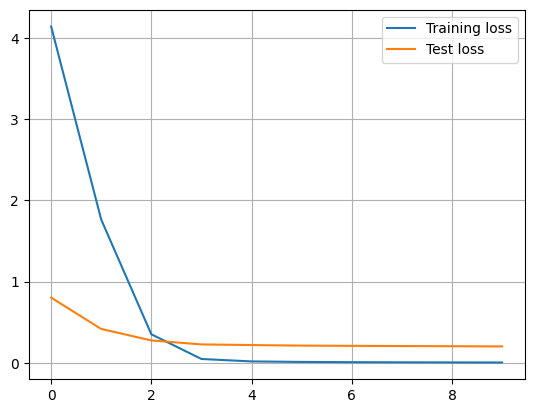

In [42]:
print(type(train_lossesV3), type(test_lossesV3))
plt.plot(train_lossesV3, label="Training loss")
plt.plot(test_lossesV3, label="Test loss")
plt.legend()
plt.grid()

In [43]:
img = images[0]
img = img.to(device)
img = img.view(-1, 3, 250, 250)
print(img.shape)

# Sice we want to use already pretrained wieghts to make some predicition
# we are turing of gradients
with torch.no_grad():
  logits = modelV3.forward(img)

torch.Size([1, 3, 250, 250])


In [44]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    modelV3.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [45]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({names[le.inverse_transform([test_labels[0]])[0]]})")

Test sample image shape: torch.Size([3, 250, 250])
Test sample label: 99 (Megawati_Sukarnoputri)


In [46]:
# Make predictions on test samples with model 2
pred_probs = make_predictions(model=modelV3,
                              data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[1.6777e-04, 1.1672e-02, 5.8978e-03, 4.0232e-04, 5.1869e-04, 1.7772e-04,
         3.2272e-05, 4.0424e-03, 1.5849e-03, 6.6258e-04, 9.1145e-05, 5.5374e-06,
         2.9650e-03, 1.4696e-03, 9.9794e-06, 3.0837e-04, 3.0824e-04, 1.1580e-04,
         1.5838e-03, 1.0067e-04, 6.7206e-05, 1.7861e-03, 5.4227e-05, 2.9136e-04,
         9.2173e-04, 7.9134e-04, 4.3707e-05, 1.3597e-05, 2.3947e-05, 1.0699e-04,
         8.3642e-05, 1.2148e-03, 7.8793e-05, 4.3773e-05, 8.1725e-04, 3.3644e-05,
         4.9860e-05, 6.2576e-02, 2.7647e-04, 2.3807e-05, 2.8592e-04, 9.3284e-05,
         5.2196e-03, 7.6305e-04, 3.7005e-04, 2.6294e-04, 5.8964e-04, 9.7911e-06,
         2.9369e-03, 1.0462e-03, 4.0557e-04, 4.5743e-05, 7.0663e-05, 1.8053e-03,
         1.3234e-04, 2.5934e-05, 1.9616e-04, 6.6277e-06, 1.5530e-04, 1.6274e-04,
         7.0767e-05, 7.8090e-04, 1.7709e-05, 3.3485e-04, 5.5252e-03, 1.4705e-03,
         7.1909e-04, 2.6026e-03, 4.0149e-05, 2.4548e-04, 7.2320e-05, 2.0373e-05,
         1.0153e-02, 1.1780e

In [47]:
# Turn the prediction probabilities into prediction labells by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([ 99, 141, 139,  82,  43,  19,  28,  35, 109])

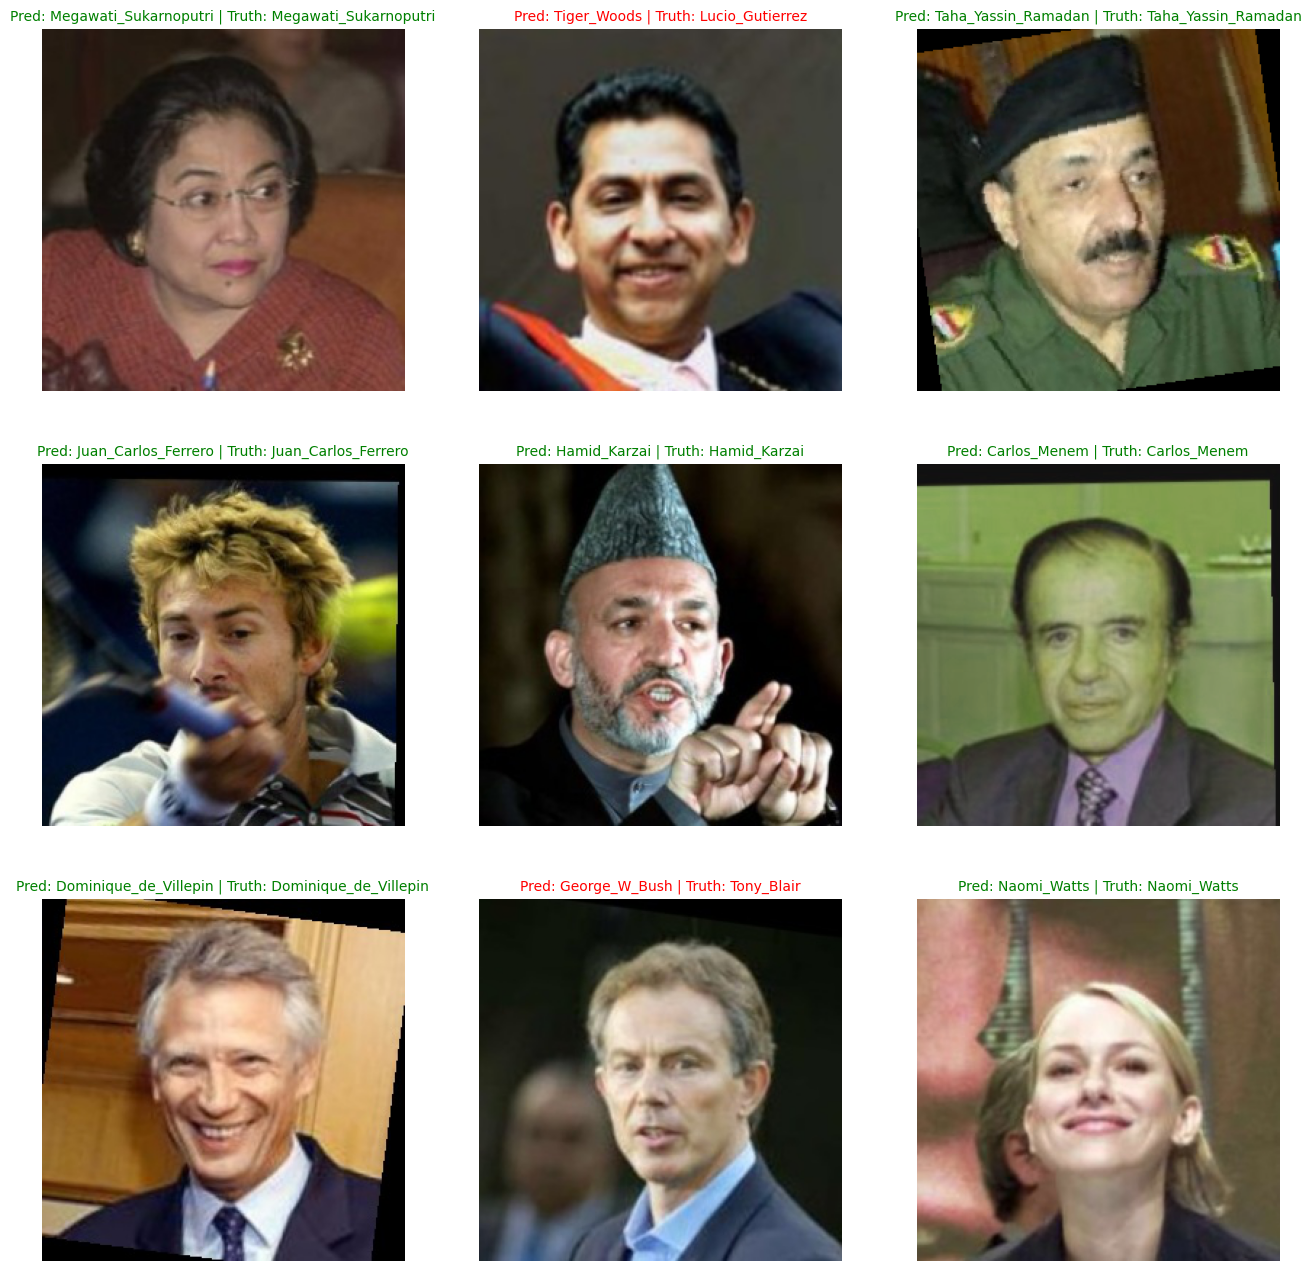

In [48]:
# Plot predictions
plt.figure(figsize=(16,16))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.permute(1,2,0))

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = names[le.inverse_transform([pred_classes[i]])[0]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = names[le.inverse_transform([test_labels[i]])[0]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

Let's modify modelV3 to get more better accuracy


In [49]:
class ModifyDeepID(nn.Module):
    def __init__(self):
        super(ModifyDeepID, self).__init__()

                # First convolutional block
        self.conv1 = nn.Conv2d(3, 20, kernel_size=3, stride=1, padding=1) #[250]
        self.bn1 = nn.BatchNorm2d(20)
        self.rel1 = nn.ReLU(inplace=True)
        self.conv12 = nn.Conv2d(20, 20, kernel_size=3, stride=1, padding=1) #[250]
        self.bn12 = nn.BatchNorm2d(20)
        self.rel12 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)#[125]

        # Second convolutional block
        self.conv2 = nn.Conv2d(20, 40, kernel_size=4, stride=1, padding=0)#[122]
        self.bn2 = nn.BatchNorm2d(40)
        self.rel2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)#[61]
        #self.dropout22 = nn.Dropout(p=0.2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(40, 60, kernel_size=4, stride=1, padding=0)#[58]
        self.bn3 = nn.BatchNorm2d(60)
        self.rel3 = nn.ReLU(inplace=True)
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)#[29]
        self.dropout3 = nn.Dropout(p=0.2)

        #four conv block
        self.conv44 = nn.Conv2d(60, 80, kernel_size=4, stride=1, padding=0)#[26]
        self.bn44 = nn.BatchNorm2d(80)
        self.rel44 = nn.ReLU()
        self.pool44 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout44 = nn.Dropout(p=0.2)



    

        # Fully connected layers
        self.fc4 = nn.Linear(80 * 13 * 13, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.rel4 = nn.ReLU(inplace=True)
        self.dropout4 = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(1024, out_features=len(set(new_dataset.labels)))

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.rel1(x)
        x = self.conv12(x)
        x = self.bn12(x)
        x = self.rel12(x)
        x = self.pool1(x)

        # Second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.rel2(x)
        x = self.pool2(x)
        #x = self.dropout22(x)

        # Third convolutional block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.rel3(x)
        
        x = self.pool3(x)
        x = self.dropout3(x)

        #four
        x = self.conv44(x)
        x = self.bn44(x)
        x = self.rel44(x)
        x = self.pool44(x)
        x = self.dropout44(x)



        # Flatten the output from convolutional blocks
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.rel4(x)
        x = self.dropout4(x)
        x = self.fc5(x)

        return x

In [50]:
modelV3_mod = ModifyDeepID()
modelV3_mod.to(device)
print(modelV3_mod)

ModifyDeepID(
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel1): ReLU(inplace=True)
  (conv12): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn12): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel12): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 40, kernel_size=(4, 4), stride=(1, 1))
  (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(40, 60, kernel_size=(4, 4), stride=(1, 1))
  (bn3): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel3): ReLU(inplace=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [51]:
optimizer = torch.optim.Adam(modelV3_mod.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

In [52]:
# Measure time
from timeit import default_timer as timer
train_time_start_model_3_mod = timer()

epochs = 120 # The total number of iteration

train_lossesV3_mod = []
test_lossesV3_mod = []

for epoch in range(epochs):
  # model for training
  modelV3_mod.train()
  train_loss = 0

  for idx, (images, labels) in enumerate(train_dataloader):

    # Send these >>> To GPU
    images = images.to(device)
    labels = labels.to(device)

    # Training pass
    optimizer.zero_grad()

    # Forward pass
    output = modelV3_mod(images)
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  else:
    # model for evaluation
    modelV3_mod.eval()
    test_loss = 0
    accuracy = 0

    # Turn off gradients when performing evaluation.
    # As if we don't turn it off, we  will comprise our networks weight entirely
    with torch.no_grad():
      for images, labels in test_dataloader:

        images = images.to(device)
        labels = labels.to(device) 

        log_probabilities = modelV3_mod(images)
        test_loss += criterion(log_probabilities, labels).item()

        probabilites = torch.exp(log_probabilities)
        top_prob, top_class = probabilites.topk(1, dim=1)
        predictions = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(predictions.type(torch.FloatTensor))

      train_lossesV3_mod.append(train_loss/len(train_dataloader))
      test_lossesV3_mod.append(test_loss/len(train_dataloader))

      print("Epoch: {}/{}   ".format(epoch+1, epochs),
            "Training loss: {:.4f}   ".format(train_loss/len(train_dataloader)),
            "Testing loss: {:.4f}   ".format(test_loss/len(train_dataloader)),
            "Test accuracy: {:.4f}   ".format(accuracy/len(test_dataloader)))
      
train_time_end_model_3_mod = timer()
total_train_time_model_3_mod = print_train_time(start=train_time_start_model_3_mod,
                                           end=train_time_end_model_3_mod,
                                           device=device)

Epoch: 1/120    Training loss: 4.0062    Testing loss: 0.6706    Test accuracy: 0.4067   
Epoch: 2/120    Training loss: 1.5647    Testing loss: 0.3314    Test accuracy: 0.7277   
Epoch: 3/120    Training loss: 0.5668    Testing loss: 0.1906    Test accuracy: 0.8371   
Epoch: 4/120    Training loss: 0.2002    Testing loss: 0.1614    Test accuracy: 0.8582   
Epoch: 5/120    Training loss: 0.0828    Testing loss: 0.1424    Test accuracy: 0.8746   
Epoch: 6/120    Training loss: 0.0446    Testing loss: 0.1282    Test accuracy: 0.8793   
Epoch: 7/120    Training loss: 0.0296    Testing loss: 0.1200    Test accuracy: 0.8858   
Epoch: 8/120    Training loss: 0.0195    Testing loss: 0.1157    Test accuracy: 0.8906   
Epoch: 9/120    Training loss: 0.0146    Testing loss: 0.1104    Test accuracy: 0.8993   
Epoch: 10/120    Training loss: 0.0124    Testing loss: 0.1100    Test accuracy: 0.8964   
Epoch: 11/120    Training loss: 0.0113    Testing loss: 0.1057    Test accuracy: 0.8975   
Epoch: 1

In [53]:
# Calculate model 1 results
model_3_mod_results = eval_model(model=modelV3_mod, data_loader=test_dataloader,
    device=device
)
model_3_mod_results

{'model_name': 'ModifyDeepID',
 'model_loss': 0.39289092168558476,
 'model_acc': tensor(0.9051)}

<class 'list'> <class 'list'>


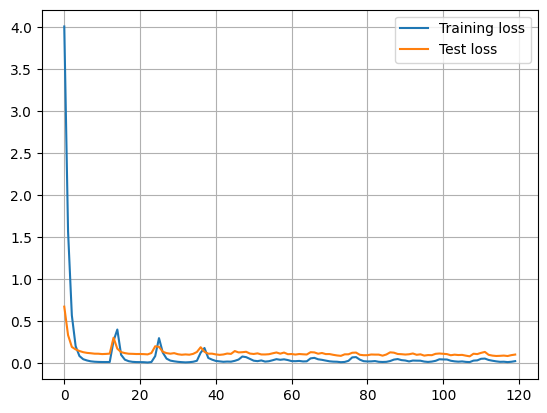

In [55]:
print(type(train_lossesV3_mod), type(test_lossesV3_mod))
plt.plot(train_lossesV3_mod, label="Training loss")
plt.plot(test_lossesV3_mod, label="Test loss")
plt.legend()
plt.grid()

In [56]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({names[le.inverse_transform([test_labels[0]])[0]]})")

Test sample image shape: torch.Size([3, 250, 250])
Test sample label: 99 (Megawati_Sukarnoputri)


In [57]:
# Make predictions on test samples with model 2
pred_probs = make_predictions(model=modelV3_mod,
                              data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[1.7656e-05, 2.5713e-04, 6.4856e-04, 4.2582e-05, 6.3176e-05, 1.0851e-05,
         1.4886e-05, 3.4752e-03, 1.8225e-04, 1.9117e-04, 6.7594e-05, 1.7492e-05,
         3.7627e-05, 3.7691e-04, 1.3707e-05, 9.8700e-05, 7.2910e-06, 7.2543e-05,
         6.2267e-05, 2.8269e-03, 1.5061e-05, 1.7239e-03, 4.1436e-06, 3.8861e-04,
         7.6380e-04, 5.4912e-05, 1.1618e-05, 1.6533e-05, 1.0162e-05, 3.2160e-05,
         1.5986e-05, 7.4615e-05, 7.3366e-06, 1.6930e-05, 4.2770e-06, 1.3629e-07,
         9.5315e-08, 1.1109e-03, 8.5591e-05, 4.2788e-06, 1.0367e-05, 3.1367e-05,
         4.7884e-04, 4.0057e-06, 3.6271e-05, 6.0259e-06, 3.4489e-05, 4.8979e-05,
         5.7947e-03, 1.1372e-06, 1.2967e-06, 1.9130e-05, 1.0530e-04, 4.2405e-04,
         6.5700e-05, 5.2508e-05, 1.1952e-04, 4.1245e-06, 2.3396e-04, 1.3408e-05,
         1.1425e-05, 4.2156e-07, 1.0039e-06, 4.8633e-05, 1.5971e-04, 1.2838e-05,
         3.1751e-04, 2.6772e-03, 9.1968e-05, 1.3484e-04, 1.3310e-05, 1.3227e-06,
         3.0605e-04, 8.0801e

In [58]:
# Turn the prediction probabilities into prediction labells by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([ 99,  36, 139,  82,  43,  19,  28,  16, 109])

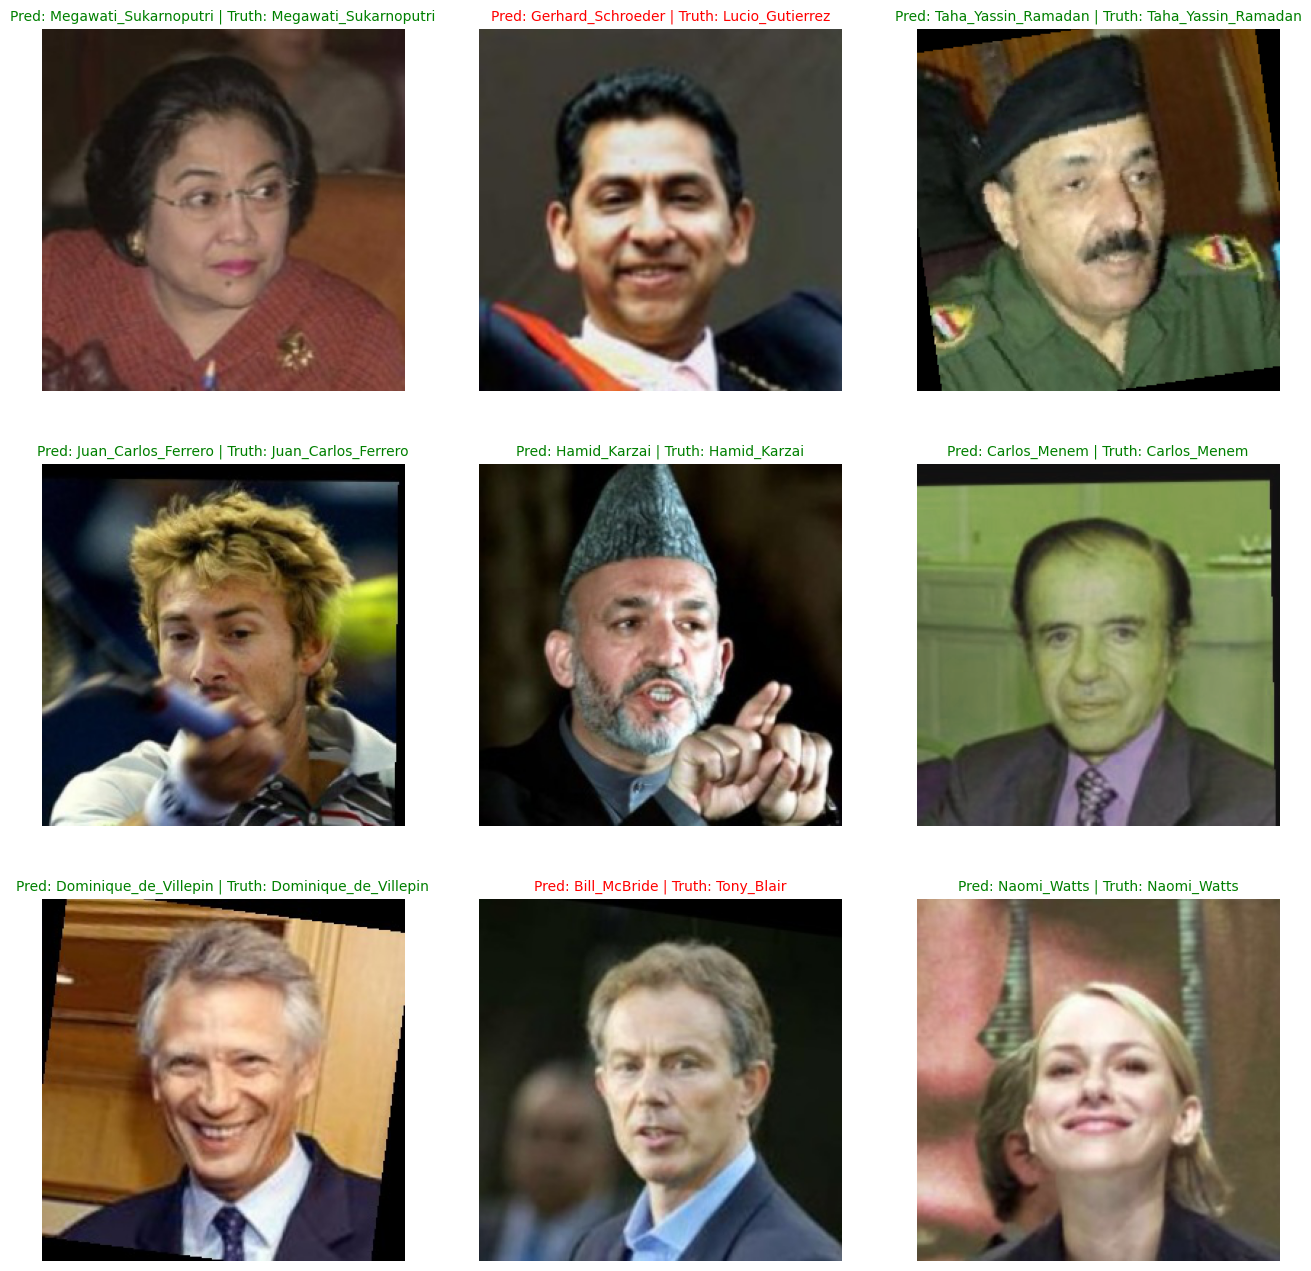

In [59]:
# Plot predictions
plt.figure(figsize=(16,16))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.permute(1,2,0))

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = names[le.inverse_transform([pred_classes[i]])[0]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = names[le.inverse_transform([test_labels[i]])[0]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);